In [2]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt

[Taichi] version 1.0.3, llvm 10.0.0, commit fae94a21, osx, python 3.9.6
[I 06/16/22 12:26:02.430 17786985] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout


In [3]:
ti.init(arch=ti.gpu)

[Taichi] Starting on arch=metal


In [4]:
# 定义一个一维时变电磁场，用一个field表示对应时刻下的这个场
# 场的大小：多少个空间步长
Space_size = 400
Space = range(Space_size)
# 模拟的时间步长
Time_steps = 300000
# 场的各项参数
imp0 = ti.field(ti.f32, shape=Space_size)
# 定义电场
Electric_field_z = ti.field(ti.f32, shape=Space_size)
# 定义磁场
Magnetic_field_z = ti.field(ti.f32, shape=Space_size)

In [5]:
#电磁学常数生成
@ti.kernel
def Initialize_imp0():
    for i in imp0:
        imp0[i] = ti.sin(i/100)# ti.random(dtype=ti.f32)

In [6]:
# 定义电场和磁场更新函数
# 电场更新函数
@ti.func
def Electric_renew():
    for i in range(1,Space_size):
        Electric_field_z[i] = Electric_field_z[i] + (Magnetic_field_z[i] - Magnetic_field_z[i-1])*imp0[i]

# 磁场更新函数
@ti.func
def Magnetic_renew():
    for i in range(0,Space_size-1):
        Magnetic_field_z[i] = Magnetic_field_z[i] + (Electric_field_z[i+1] - Electric_field_z[i])/imp0[i]

# 硬源
@ti.func
def Electric_source(t_step: ti.f32):#t_step是时间步
    Electric_field_z[0] = ti.exp(-(t_step-30.0)**2/100.0)

#总更新函数
@ti.kernel
def Electric_magnetic_renew(time_step: ti.f32):
    Magnetic_renew()
    Electric_renew()
    Electric_source(t_step=time_step)

In [7]:
Initialize_imp0()
imp0_np = imp0.to_numpy()


KeyboardInterrupt



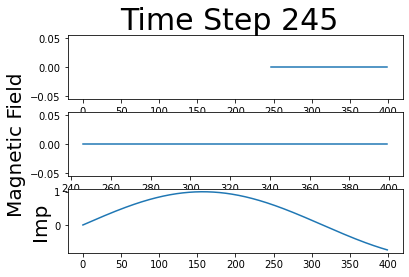

In [8]:
for time_step_num in range(Time_steps):
    Electric_magnetic_renew(time_step=time_step_num)
    Magnetic_output = Magnetic_field_z.to_numpy()
    Electric_output = Electric_field_z.to_numpy()
    #清除刷新前的图表，防止数据量过大消耗内存
    plt.clf()
    # 添加总标题，并设置文字大小
    plt.suptitle("Time Step {:.0f}".format(time_step_num),fontsize=30)
    Graphic_one = plt.subplot(3,1,1)
    Graphic_one.set_ylabel("Electric Field",fontsize=20)
    # Graphic_one.set_xlabel('Space',fontsize=15)
    plt.plot(Space, Electric_output)
    Graphic_two = plt.subplot(3,1,2)
    Graphic_two.set_ylabel('Magnetic Field',fontsize=20)
    # Graphic_two.set_xlabel('Space',fontsize=15)
    plt.plot(Space, Magnetic_output)
    Graphic_three = plt.subplot(3,1,3)
    Graphic_three.set_ylabel('Imp',fontsize=20)
    # Graphic_three.set_xlabel('Space',fontsize=15)
    plt.plot(Space, imp0_np)
    # plt.pause(0.1)